<a href="https://colab.research.google.com/github/poziryna84/Fake-News-Recognizer/blob/master/Fake_News_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import spacy
from spacy.lang.en import English
nlp = spacy.load('en_core_web_sm')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics

# Functions

In [ ]:
def json_splitter(column):
  ''' Function that identifies the incorrectly stored .json files among the rows
  of the data frame and creates the id list with their indexes;
  splits the strings into separate comments and their labels and saves them into
  a data frame. 
  '''
  inds = []
  labels = []
  texts = []
  pattern = r'\t.+?\n\d+.json\t\w+-?\w+?\t'
  labe_pattern = r'.json\t(.+?)\t'
  text_pattern = r'.+\t.+?\n\d+.json\t\w+-?\w+?\t'
  lab_dict = {'barely-true': 0, 'false': 1, 'pants-fire': 1, 'half-true': 2, 
              'mostly-true': 3, 'not-known': 4, 'true': 5}
  for ind in column.index:

    string = column[ind]
    
    if len(re.findall(pattern, string))>0:
      inds.append(ind)
      aux_labels = re.findall(labe_pattern, string)
      num_labels = [lab_dict[l] for l in aux_labels]
      labels = labels + num_labels

      aux_texts = re.findall(text_pattern, string)
      for text in aux_texts:
        text = re.sub(r'\t.+?\n\d+.json\t\w+-?\w+?\t','', text)
        texts.append(text)
  data = {'Labels': labels,
          'Text': texts
          }
  df = pd.DataFrame(data)
  df['text_len'] = df.Text.apply(len)
  return df, inds

def spacy_counter(df, type_, text_column, target_column):
    '''Functions that return a number of parts of speech or entetis from a 
    string.
    '''

    def stop_words_count(text):
      doc = nlp(text)
      n_stop = [t.text for t in doc  if t.text in STOP_WORDS]
    
      return len(n_stop)
    
    def partofSpeachRec(text,tag):
        doc = nlp(text)
        pos = [token.pos_ for token in doc]
        return pos.count(tag)
    def entetiesRecog(text, tag):
        doc = nlp(text)
        labels = [ent.label_ for ent in doc.ents]
        return labels.count(tag)
        
    ps_dict = {'ADJ': 'adjectives', 'ADP': 'prepositions', 'ADV': 'adverb',
              'NOUN': 'nouns', 'NUM': 'numerals', 'PRON': 'pronouns', 
               'PROPN': 'proper nouns', 'VERB': 'verbs'}
    ent_dict = {'PERSON': 'People, including fictional',
                'GPE': 'Countries, cities, states.', 
                'DATE': 'Absolute or relative dates or periods',
                'TIME': '	Times smaller than a day', 
                'ORDINAL': 'Ordinal numbers', 'CARDINAL': 'Cardinal numbers'}
    
    stop_dict = {'STOP_WORDS': 'Number of stop words'}
     
    if type_ == 'stop_words':
      
      function = stop_words_count
      dictionary = stop_dict

    elif type_ == 'part_of_speech':
        
        function = partofSpeachRec
        dictionary = ps_dict

    elif type_ == 'entety_label':
        
        function = entetiesRecog
        dictionary = ent_dict

    for i in dictionary.keys():
      if i == 'STOP_WORDS':
        df[i] = df[text_column].apply(lambda x: function(x))
      else:
        df[i] = df[text_column].apply(lambda x: function(x, i))
      plot_test=df[i].hist(by=df[target_column], sharex=True,bins = 15)
      plt.suptitle("The %s distribution by label"% (dictionary[i]))
        
    return df


def text_cleaner(string):
  '''Function that converts a string to lowercase and removes punctuations,
   numbers and characters and then strips it;
   removes Stopwords and long spaces;
   performs Lemmatisation.
  '''
  string = re.sub(r'-', ' ', str(string))
  string = re.sub(r'[^\w\s]', '', str(string).lower().strip())
  string = re.sub(r'\d+', '', string)
  doc = nlp(string)
  lems = [i.lemma_ for i in doc if ((i.text not in STOP_WORDS) & (len(i.lemma_) > 2))]
  text = " ".join(lems)
  text = re.sub(' +', ' ', text)
  return text.strip()

def statsByLabel(df, columns, target_column):
  for i in columns:
    tot_col = [i, target_column]
    print(df[tot_col].groupby(target_column).mean())

# Loading and cleaning data

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/Participants_Data_WH20/Train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Participants_Data_WH20/Test.csv')
sub = pd.read_csv('/content/drive/My Drive/Participants_Data_WH20/sample submission.csv')

In [ ]:
train_data.shape

(10240, 3)

In [ ]:
train_data.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


**Identifying and removing duplicated rows**

In [ ]:
train_data.duplicated().sum()

8

In [ ]:
train_data = train_data.drop_duplicates()

After removing the duplicated rows, duplicated Text rows with different Labels were identified. These occurrence will be challenging as they might confuse the algorythm.

In [ ]:
train_data[train_data['Text'].duplicated(keep = False)]

,Labels,Text,Text_Tag
709,1,On abortion,"abortion,corrections-and-updates"
931,5,On support for gay marriage.,gays-and-lesbians
1014,2,On abortion,"abortion,candidates-biography"
1071,5,On torture.,military
1526,2,"Four balanced budgets in a row, with no new ta...","education,state-budget,state-finances"
1814,1,On support for gay marriage.,"civil-rights,families,gays-and-lesbians,marriage"
1899,5,Six justices on the U.S. Supreme Court have be...,"history,supreme-court"
2846,3,"Four balanced budgets in a row, with no new ta...","job-accomplishments,jobs,state-budget,state-fi..."
2872,1,On a cap-and-trade plan.,"cap-and-trade,climate-change,jobs"
3256,1,On a cap-and-trade plan.,"cap-and-trade,climate-change,environment"


**Analysing the length of the comments**

As the plot shows there are some obvious outliers among the lengths of the comments which should be further investigated.

In [ ]:
train_data['text_len'] = train_data.Text.apply(len)

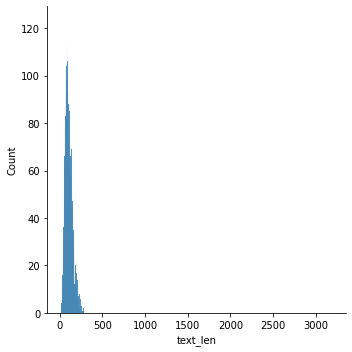

In [ ]:
import seaborn as sns
sns.displot(train_data, x="text_len", binwidth=1)

In [ ]:
train_data.text_len.describe()

count    10232.000000
mean       106.949668
std         59.912564
min         11.000000
25%         73.000000
50%         99.000000
75%        133.000000
max       3192.000000
Name: text_len, dtype: float64

Apparently those are .json files which were not stored properly and represent multiple comments with their labels and some additional information, such as text tag, etc. in the same row.

In [ ]:
train_data.Text[train_data.text_len > 500].values

array(['Hospitals, doctors, MRIs, surgeries and so forth are more extensively used and far more expensive in this country than they are in many other countries.\'\'\thealth-care\tmitt-romney\tFormer governor\tMassachusetts\trepublican\t34\t32\t58\t33\t19\ta Fox News Sunday interview\n9874.json\tbarely-true\tObamacare cuts seniors Medicare.\thealth-care,medicare\ted-gillespie\tRepublican strategist\tWashington, D.C.\trepublican\t2\t3\t2\t2\t1\ta campaign email.\n3072.json\tmostly-true\tThe refusal of many federal employees to fly coach costs taxpayers $146 million annually.\tgovernment-efficiency,transparency\tnewsmax\tMagazine and website\tFlorida\tnone\t0\t0\t0\t1\t0\tan e-mail solicitation\n2436.json\tmostly-true\tFlorida spends more than $300 million a year just on children repeating pre-K through 3rd grade.\teducation\talex-sink\t\tFlorida\tdemocrat\t1\t2\t2\t4\t0\tfigures cites on campaign website\n9721.json\ttrue\tMilwaukee County Sheriff David A. Clarke Jr. advised citizens to p

To address this problem we will use json_splitter function created to drop those rows and append the data frame with the 'clean' comments and their labels.

In [ ]:
df_aux, ids = json_splitter(train_data.Text)
train_data = train_data[~train_data.index.isin(ids)]
train_data = pd.concat([train_data, df_aux], axis = 0, ignore_index = True)

# Text Analysis

**Target variable**

*For more readability we are going the replace the 
integer values with their definitions.*

In [ ]:
label_dict = {0: 'Barely-True', 1: 'False', 2: 'Half-True', 
                  3: 'Mostly-True', 4: 'Not-Known', 5: 'True'}
train_data['label_text'] = train_data['Labels'].map(label_dict)

As the below plot shows there are 6 categories to be predicted. 

*   8% of the data, labeled as 'Not-Known', will present the main challenge at the stage of the prediction, as each of its comments belongs to one of the rest of the labels and therefore will confuse the model.
*   Even though we could potentially call it a balanced data set, some of the other labels aren't very clear/different from each other, such as Half-True and Barely-True. Their ambiguousness will add nothing but noise to the model.


In [ ]:
train_data.label_text.value_counts(normalize = True)

Half-True      0.206903
False          0.194325
Mostly-True    0.191595
True           0.163904
Barely-True    0.161466
Not-Known      0.081806
Name: label_text, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Labels')

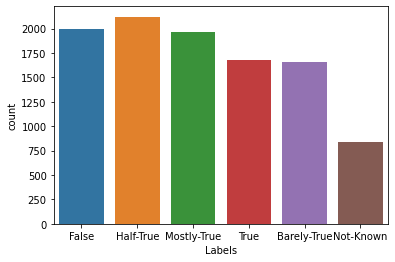

In [ ]:
sns.countplot(train_data.label_text)
plt.xlabel('Labels')

**Part of speech analysis**

According to the plots and statistics below

*   fake news have fewer adjectives(ADJ), nouns, prepositions(ADP) and adverbs(ADV), while having more verbs, which means that there is more 'action' focus of the fake news;
*   interestingly on average there are fewer pronouns used by those who fake news, that minimizes references to themselves. A person who is lying tends not to use 'we' and 'I', i.e. tends not to use personal pronouns; 
*   Even though on average there are more notions proper nouns(PROPN) in fake news, numbers are more common among real news(NUM) which implies more details in the latter.

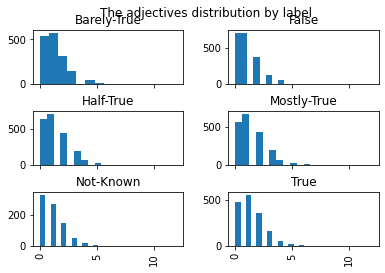

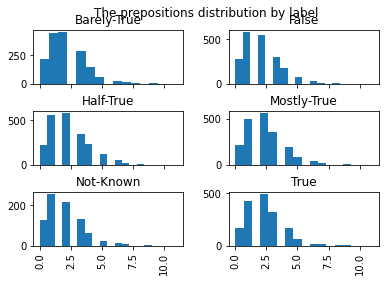

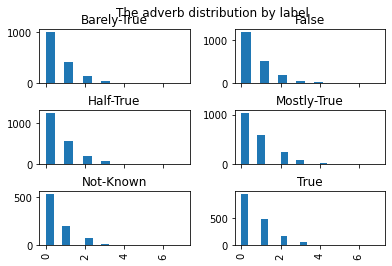

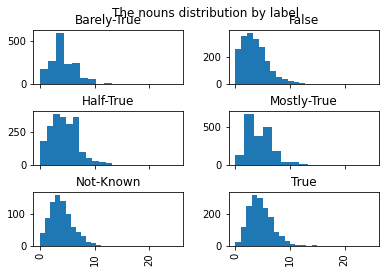

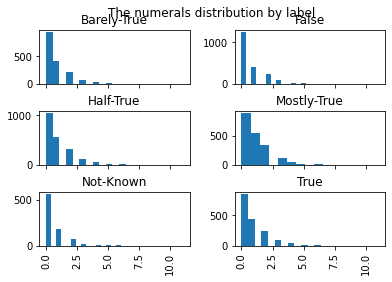

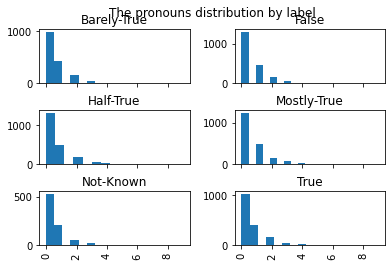

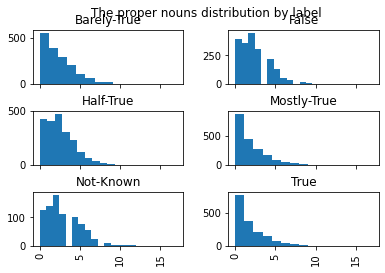

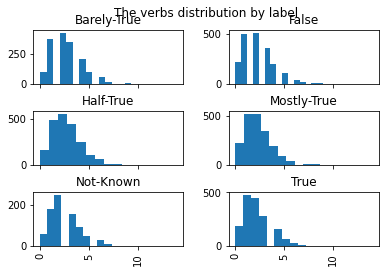

In [ ]:
ps = spacy_counter(train_data, 'part_of_speech', 'Text', 'label_text')

In [ ]:
c = ['ADJ', 'ADP', 'ADV', 'NOUN', 'NUM', 'PRON', 'PROPN', 'VERB']
statsByLabel(train_data, c, 'label_text')

                  ADJ
label_text           
Barely-True  1.206522
False        1.065228
Half-True    1.298775
Mostly-True  1.359796
Not-Known    1.019070
True         1.333730
                  ADP
label_text           
Barely-True  2.059179
False        1.953838
Half-True    2.248822
Mostly-True  2.183206
Not-Known    1.886770
True         2.172516
                  ADV
label_text           
Barely-True  0.592995
False        0.600602
Half-True    0.623940
Mostly-True  0.724682
Not-Known    0.556615
True         0.651993
                 NOUN
label_text           
Barely-True  4.146135
False        3.856498
Half-True    4.392554
Mostly-True  4.309924
Not-Known    3.760429
True         4.171921
                  NUM
label_text           
Barely-True  0.736715
False        0.636227
Half-True    0.911876
Mostly-True  0.972010
Not-Known    0.518474
True         0.878644
                 PRON
label_text           
Barely-True  0.622585
False        0.559458
Half-True    0.601320
Mostly-Tru

**Entety analysis**

Even though famous people a slightly more common to be discussed in fake news, when it comes to more specific details such as time, geographic location(GPE), date and numbers (both ordinal and cardinal), real news contain more of it.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


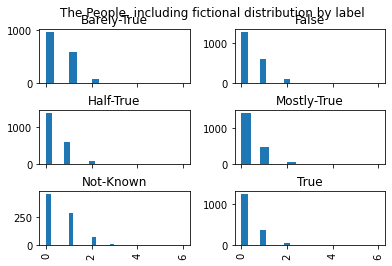

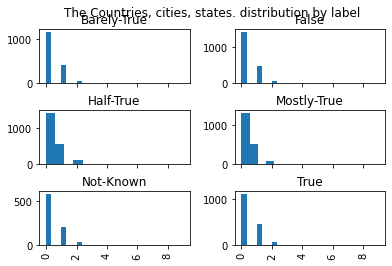

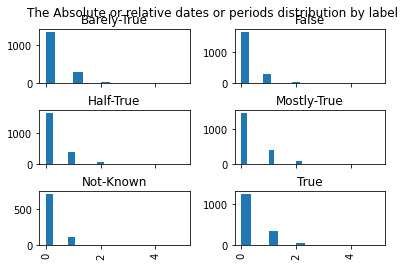

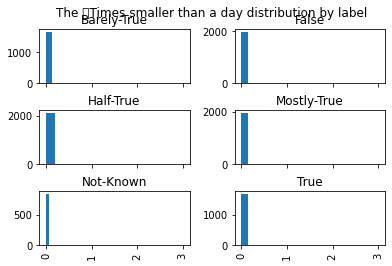

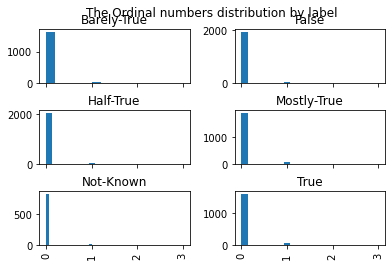

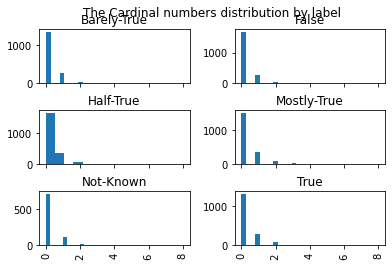

In [ ]:
check_ent = spacy_counter(train_data, 'entety_label', 'Text', 'label_text')

In [ ]:
c = ['PERSON', 'GPE', 'DATE', 'TIME', 'ORDINAL', 'CARDINAL']
statsByLabel(train_data, c, 'label_text')

               PERSON
label_text           
Barely-True  0.495169
False        0.435023
Half-True    0.411876
Mostly-True  0.331807
Not-Known    0.570918
True         0.323617
                  GPE
label_text           
Barely-True  0.352657
False        0.356749
Half-True    0.423657
Mostly-True  0.417303
Not-Known    0.381406
True         0.407496
                 DATE
label_text           
Barely-True  0.220411
False        0.205720
Half-True    0.275212
Mostly-True  0.322137
Not-Known    0.187128
True         0.318263
                 TIME
label_text           
Barely-True  0.014493
False        0.008530
Half-True    0.008011
Mostly-True  0.009669
Not-Known    0.003576
True         0.010708
              ORDINAL
label_text           
Barely-True  0.028382
False        0.033618
Half-True    0.038643
Mostly-True  0.050382
Not-Known    0.019070
True         0.052350
             CARDINAL
label_text           
Barely-True  0.212560
False        0.198194
Half-True    0.297361
Mostly-Tru

**Stop words analysis**

As for the stop words, on average there are fewer of them in fake news which make it more concise and brief.

,Labels,Text,Text_Tag,text_len,label_text,ADJ,ADP,ADV,NOUN,NUM,PRON,PROPN,VERB,PERSON,GPE,DATE,TIME,ORDINAL,CARDINAL,STOP_WORDS
0,1,Says the Annies List political group supports ...,abortion,82,False,2,1,0,4,0,0,2,2,0,0,0,0,1,0,3
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",141,Half-True,1,3,2,5,0,1,4,4,1,0,0,0,0,0,8
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,105,Mostly-True,0,4,0,2,0,0,7,3,3,1,0,0,0,0,8
3,1,Health care reform legislation is likely to ma...,health-care,78,False,2,0,0,7,0,0,0,1,0,0,0,0,0,0,2
4,2,The economic turnaround started at the end of ...,"economy,jobs",54,Half-True,1,2,0,3,0,0,0,1,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10251,5,Says U.S. Senate hopeful Tammy Baldwin voted f...,NaN,134,True,3,1,0,3,3,0,4,4,1,0,0,0,0,0,5
10252,0,Says Clinton did not read the National Intelli...,NaN,92,Barely-True,0,2,0,1,0,0,5,3,1,0,0,0,0,0,6
10253,3,Thanks to the Act 10 collective bargaining law...,NaN,194,Mostly-True,3,4,4,10,2,0,3,2,0,1,1,0,1,1,16
10254,2,"Our income, our GDP per capita, is almost 50 p...",NaN,98,Half-True,2,2,1,4,1,1,1,0,0,0,0,0,0,0,9


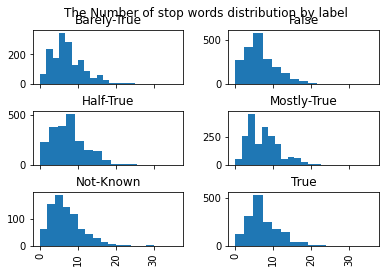

In [ ]:
spacy_counter(train_data, 'stop_words', 'Text', 'label_text')

In [ ]:
c = ['STOP_WORDS']
statsByLabel(train_data, c, 'label_text')

             STOP_WORDS
label_text             
Barely-True    7.205918
False          6.753638
Half-True      7.580113
Mostly-True    7.526209
Not-Known      6.618594
True           7.535990


# Preprocessing data

We cleaned the text by converting a string to lowercase and removing punctuations, numbers and characters and then striping it.
After Stopwords and long spaces were removed we performed Lemmatisation.

In [ ]:
train_data['clean_text'] = train_data.Text.apply(text_cleaner)

# Splitting the data into train and test

In [ ]:
dtf_train, dtf_test = model_selection.train_test_split(train_data, 
                                                       test_size=0.15)

y_train = dtf_train['Labels'].values
y_test = dtf_test['Labels'].values

# Bag-of-Words

**Feature Engineering**

We are going use the Tf-Idf vectorizer with a limit of 50,000 words (so the length of my vocabulary will be 50k), capturing unigrams (i.e. 'San' and 'Francisco') and bigrams (i.e. 'San Francisco').

In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features = 50000, ngram_range=(1,2))

Let's use vectorizer on the preprocessed corpus of the train set to extract a vocabulary and create the feature matrix.

In [ ]:
corpus = dtf_train['clean_text']
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
X_train.shape

(8717, 50000)

Text(0.5, 1.0, 'Sparse Matrix Sample')

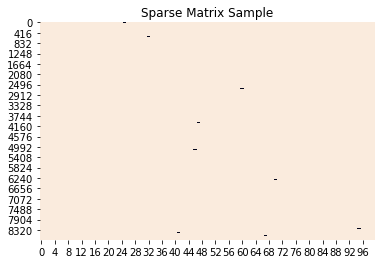

In [ ]:
sns.heatmap(
    X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False
    ).set_title('Sparse Matrix Sample')

# Feature selection

Chi-square test measures dependence between stochastic variables, so using this function 'weeds out' the features that are the most likely to be independent of class and therefore irrelevant for classification.

I am going to treat each category as binary (for example, the 'Fake' news is 1 for the Fake news and 0 for the others)

In [ ]:
y = dtf_train['Labels']
X_names = vectorizer.get_feature_names()
p_value_limit = 0.85

In [ ]:
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [ ]:
len(dtf_features)

5873

We reduced the number of features from 7500 to 5910 by keeping the most statistically relevant ones. Let's print them out by label.

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 593
  . top features: decide vote,say billion,federal reserve,fleet,support high,create american,vote obamacare,republicans try,mccain tax,pay woman
 
# 1:
  . selected features: 344
  . top features: scheme,terry,terry mcauliffe,ponzi scheme,vote tax,debunk,mcauliffe,ponzi,jan,work private
 
# 2:
  . selected features: 253
  . top features: medicare fraud,cost georgia,dropout,romney governor,outsource,create million,anytime,say oppose,gun people,dropout rate
 
# 3:
  . selected features: 321
  . top features: high corporate,rate world,dollar man,segregated,pay national,visa,not court,owe,sixth,percent
 
# 4:
  . selected features: 3684
  . top features: stimulus create,transaction,inch away,socialist,apology tour,begin presidency,obama begin,history world,create zero,zero job
 
# 5:
  . selected features: 678
  . top features: year record,sen obama,flop abortion,reagan raise,raise debt,percent hispanic,compensation,asset,elect state,court confirm
 


No it's time to refit the vectorizer on the corpus by giving this new set of words as input. That will produce a smaller feature matrix and a shorter vocabulary.

In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary = X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
X_train.shape

(8717, 5866)

Text(0.5, 1.0, 'Sparse Matrix Sample')

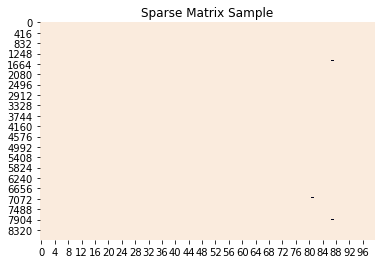

In [ ]:
sns.heatmap(
    X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False
    ).set_title('Sparse Matrix Sample')

# Machine learning model - Naive Bayes

Naive Bayes algorithm: a probabilistic classifier that makes use of Bayes’ Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

In [ ]:
classifier = naive_bayes.MultinomialNB()

For the training purposes we will use the feature matrix and then test it on the transformed test set. I need to build a scikit-learn pipeline: a sequential application of a list of transformations and a final estimator. 

In [ ]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test['clean_text'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

# Model Evaluation

Accuracy: 0.22
Auc: 0.56
Detail:
              precision    recall  f1-score   support

           0       0.21      0.07      0.10       246
           1       0.22      0.12      0.16       297
           2       0.20      0.56      0.30       318
           3       0.23      0.30      0.26       279
           4       0.33      0.01      0.02       128
           5       0.34      0.07      0.11       271

    accuracy                           0.22      1539
   macro avg       0.26      0.19      0.16      1539
weighted avg       0.25      0.22      0.18      1539



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <a list of 6 Text major ticklabel objects>)

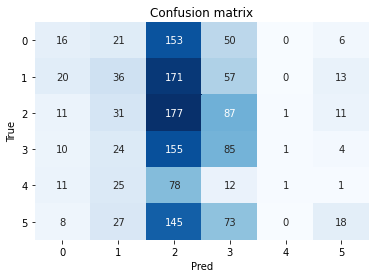

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)